#Multi-Class Classification
###Image Shape - (150,150)
###Number of Classes - 3
###Metric - AUC

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import gc
from itertools import cycle



In [ ]:
# from google.colab import drive
# drive.mount("/content/gdrive")

In [ ]:
# !unzip /content/gdrive/MyDrive/dataset.zip

### Reading and preparing data

In [9]:
# Get CSV files list from a folder

path_to_train =                             #'/content/dataset/train/'

npy_no = glob.glob(path_to_train + "no/*.npy")
npy_sphere = glob.glob(path_to_train + "sphere/*.npy")
npy_vort = glob.glob(path_to_train + "vort/*.npy")

images_no = np.array([np.load(file).astype('float32') for file in npy_no])
images_sphere = np.array([np.load(file).astype('float32') for file in npy_sphere])
images_vort = np.array([np.load(file).astype('float32') for file in npy_vort])


image_train = np.concatenate((images_no,images_sphere,images_vort))
X_train = image_train.reshape(-1,150,150,1)

### Creating labels

In [10]:
labels = np.empty(30000).astype('uint8')
labels[0:10000] = 1
labels[10000:20000] = 2
labels[20000:] = 3
y_train = pd.get_dummies(labels).values   # one-hot encoding


### Reading validation data and creating labels

In [11]:
pathv_to_val = "/content/dataset/val/"

vals_no = glob.glob(pathv_to_val + "no/*.npy")
vals_sphere = glob.glob(pathv_to_val + "sphere/*.npy")
vals_vort = glob.glob(pathv_to_val + "vort/*.npy")

val_no = np.array([np.load(file).astype('float32') for file in vals_no])
val_sphere = np.array([np.load(file).astype('float32') for file in vals_sphere])
val_vort = np.array([np.load(file).astype('float32') for file in vals_vort])


image_val = np.concatenate((val_no,val_sphere,val_vort))
X_val = image_val.reshape(-1,150,150,1)

labels = np.empty(7500).astype('uint8')
labels[0:2500] = 1
labels[2500:5000] = 2
labels[5000:] = 3
y_val = pd.get_dummies(labels).values

Deleting temporary variables

In [12]:
del image_train
del images_no
del images_sphere
del images_vort
del labels

del image_val
del val_no
del val_sphere
del val_vort


gc.collect()

363

## Importing important Keras functions

In [13]:
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.initializers import TruncatedNormal
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D,RandomFlip ,RandomRotation,RandomCrop
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from tensorflow.keras.metrics import AUC
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.random import set_seed

from sklearn.metrics import roc_curve, auc

set_seed(42)

Setting parameters for the model

In [14]:
lr_init     = 1.e-4     # Initial learning rate - Fastest convergence after comparing different values  
batch_size  = 64       # Training batch size
epochs      = 25       # Number of epochs
doGPU       = True    # Use GPU
img_rows = 150
img_cols = 150

In [15]:
if doGPU:
    import tensorflow.compat.v1 as tf
    from tensorflow.compat.v1.keras.backend import set_session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    set_session(tf.Session(config=config))

Augmentation layer to prevent overfitting

In [16]:
data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal_and_vertical"),    # Random flipping of the image
  RandomRotation((0,1)),                    # Rotation from 0 to 360 degrees
  RandomCrop(150,150)                       # random cropping 
])

#Main Model

ResNet50 

Pre-trained weight

All layers trainable

Pre-trained weights helps in converging early, so does the making all the layers trainable (determined by experimentation).

To feed the image to ResNet, image had to be made of 3 channels.
There were 2 options.
1. Add a Convolution layer
2. Make 3 channel image with same values in all the channels.

    1st option gave better results.

Loss for multi-class classifcation - Categorical crossentropy


In [17]:
ResNet50_model = ResNet50(weights= 'imagenet', include_top=False, input_shape=(150,150,3), classes=3)  # compared with vgg-16
for layers in ResNet50_model.layers:
    layers.trainable= True

opt = Adam(learning_rate=lr_init)


model = tf.keras.Sequential([ 
                             data_augmentation,
                             Conv2D(3,(3,3),padding='same'),   
                             ResNet50_model,
                             Flatten(),
                             Dense(256,activation='relu'),
                             Dropout(0.4),
                             Dense(3,activation='softmax')
                            ])

model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['AUC'])


94781440/94765736 [==============================] - 2s 0us/step


Fitting the model.
Used 2 callbacks to reduce learning rate and for early stopping, based on changes in validation loss.

In [19]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1.e-6)
earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
history=model.fit(X_train, y_train,\
        batch_size=batch_size,\
        epochs=epochs,\
        validation_data=(X_val, y_val),\
        callbacks=[reduce_lr, earlyStopping],\
        verbose=1, shuffle=True)

Epoch 1/25
469/469 [==============================] - 408s 821ms/step - loss: 1.1436 - auc: 0.5294 - val_loss: 1.1370 - val_auc: 0.5024 - lr: 1.0000e-04
Epoch 2/25
469/469 [==============================] - 379s 808ms/step - loss: 0.9794 - auc: 0.6920 - val_loss: 1.1342 - val_auc: 0.5539 - lr: 1.0000e-04
Epoch 3/25
469/469 [==============================] - 393s 839ms/step - loss: 0.7557 - auc: 0.8377 - val_loss: 2.1347 - val_auc: 0.6885 - lr: 1.0000e-04
Epoch 4/25
469/469 [==============================] - 376s 802ms/step - loss: 0.5409 - auc: 0.9223 - val_loss: 1.6891 - val_auc: 0.7641 - lr: 1.0000e-04
Epoch 5/25
469/469 [==============================] - 379s 809ms/step - loss: 0.3924 - auc: 0.9587 - val_loss: 0.4015 - val_auc: 0.9614 - lr: 5.0000e-05
Epoch 6/25
469/469 [==============================] - 377s 803ms/step - loss: 0.3445 - auc: 0.9678 - val_loss: 0.3655 - val_auc: 0.9664 - lr: 5.0000e-05
Epoch 7/25
469/469 [==============================] - 378s 806ms/step - loss: 0.31

save model

In [ ]:
# model.save('model.h5')
# from google.colab import files
# files.download('model.h5') 

# Model Summary

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 150, 150, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 3)       30        
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 256)               13107456  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                

In [21]:
gc.collect()

1489

### Calculating Classwise AUC and plotting ROC curves.

In [22]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
n_classes = y_train.shape[1]
y_pred = model.predict(X_val)

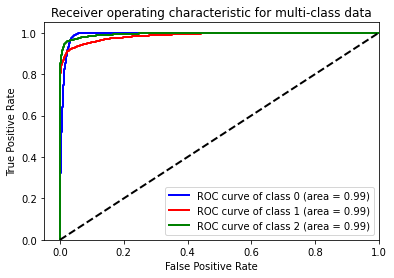

In [23]:
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()